## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [1]:
import os
from tensorflow import keras
import itertools

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 13s 0us/step


In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

In [5]:
x_train.shape

(50000, 32, 32, 3)

In [6]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
x_train.shape

(50000, 3072)

In [8]:
y_train.shape

(50000, 10)

In [9]:
from keras.layers import Dropout

"""
建立神經網路，並加入 dropout layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128, 64], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = [0.1, 0.2, 0.3, 0.4]

In [11]:
import tensorflow as tf

results = {}

for ratio in Dropout_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print(f"DRP_Ratio: {ratio}")
    model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=ratio)
    model.summary()
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

    exp_name_tag = "DRP_Ratio: %s" % (str(ratio))
    results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}
        

DRP_Ratio: 0.1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)      

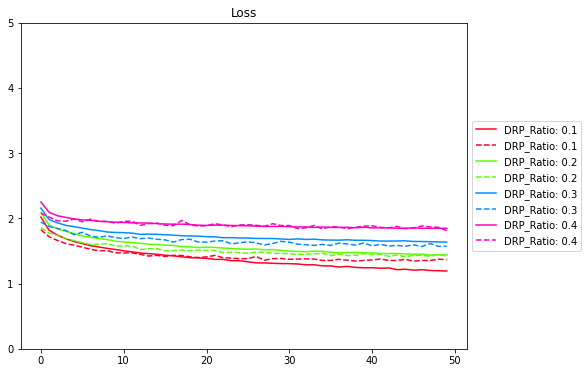

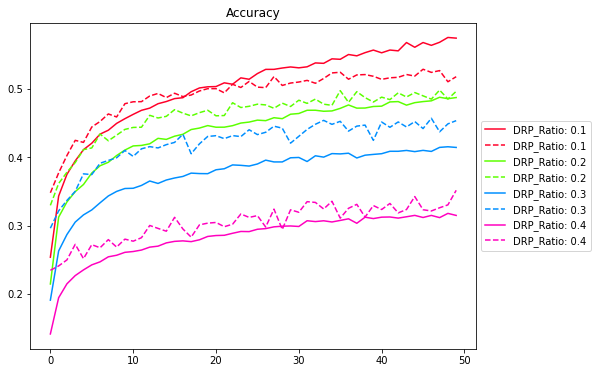

In [12]:
from matplotlib import cm as mplcm
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

NUM_COLORS = 4

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### 觀察結果: drop_ratio愈高, 會使得Accuracy下降, Loss增加, 一般用在減少overfitting, 增加模型泛化能力情況下才會使用到